# 01_import dataset

## 01-1_import data

In [1]:
import os
import json
import pandas as pd

#https://drive.google.com/drive/folders/18qV82fNY3IIWu3BRoGqm_LNgJzE8Akbr?usp=drive_link
#base_dir = "/Users/Andypon/10_交大研究所/1141_01_機器學習與金融科技/data"
base_dir= '/Users/andyw.p.chen/Documents/Project/datasets'
#base_dir=  "c:\Users\user\Downloads\datasets"

def load_json_to_df(filename: str) -> pd.DataFrame:
    file_path = os.path.join(base_dir, filename)
    with open(file_path, "r", encoding="utf-8") as f:
        data = json.load(f)

    # 如果是 { "target": {id: value, ...} }
    if isinstance(data, dict) and len(data) == 1 and isinstance(next(iter(data.values())), dict):
        key, inner = next(iter(data.items()))
        return pd.DataFrame(list(inner.items()), columns=["id", key])

    # dict of scalar
    if isinstance(data, dict):
        return pd.DataFrame([{"code": k, "desc": v} for k, v in data.items()])

    # list of dict
    elif isinstance(data, list):
        return pd.DataFrame(data)

    else:
        raise ValueError(f"Unsupported JSON structure in {filename}: {type(data)}")


def load_csv_to_df(filename: str) -> pd.DataFrame:
    """讀取 CSV 並轉為 DataFrame。"""
    return pd.read_csv(os.path.join(base_dir, filename))

# JSON 資料
##mcc_codes_df = load_json_to_df("mcc_codes.json")
train_fraud_labels_df = load_json_to_df("train_fraud_labels.json")

# CSV 資料
cards_df = load_csv_to_df("cards_data.csv")
transactions_df = load_csv_to_df("transactions_data.csv")
users_df = load_csv_to_df("users_data.csv")

# 簡單檢查
#print(mcc_codes_df.head())
#print(train_fraud_labels_df.head())
#print(cards_df.head())
#print(transactions_df.head())
#print(users_df.apthead())


## 01-2_rename variable in each data set

In [2]:
train_fraud_labels_df = train_fraud_labels_df.rename(columns={'id': 'transactions_id'})
train_fraud_labels_df = train_fraud_labels_df.rename(columns={'target': 'is_fraud'})

cards_df = cards_df.rename(columns={'id':'card_id'})

users_df = users_df.rename(columns={'id':'client_id'})

transactions_df = transactions_df.rename(columns={'mcc': 'mcc_code'})
transactions_df = transactions_df.rename(columns={'id': 'transaction_id'})




## 01-3_變數型態統一及缺失值處理

In [3]:
def add_missing_flags(df: pd.DataFrame, cols: list) -> pd.DataFrame:
    """
    在 DataFrame 中對指定欄位建立 missing flag 欄位
    flag=1 表示缺失值，flag=0 表示非缺失值
    
    參數
    ----
    df : pd.DataFrame
        輸入的資料框
    cols : list
        要檢查的欄位名稱清單
    
    回傳
    ----
    pd.DataFrame : 新的資料框 (含新增的 flag 欄位)
    """
    for col in cols:
        df[f"{col}_missing_flag"] = df[col].isna().astype(int)
    return df

transactions_df = add_missing_flags(transactions_df, ["merchant_state", "zip", "errors"])

In [4]:
##train_fraud_labels_df##
train_fraud_labels_df["is_fraud"]=train_fraud_labels_df["is_fraud"].astype("category") 
train_fraud_labels_df["transactions_id"]=train_fraud_labels_df["transactions_id"].astype(int) #合併資料需要

##cards_df##
cards_df["card_brand"]=cards_df["card_brand"].astype("category") 
cards_df["card_type"]=cards_df["card_type"].astype("category")
#####不要load這行 cards_df["expires"]=pd.to_datetime(cards_df["expires"], format="%m/%Y")
cards_df["expires"] = pd.to_datetime(cards_df["expires"], format="%m/%Y").dt.to_period("M")
cards_df["has_chip"]=cards_df["has_chip"].astype("category")

cards_df['credit_limit'] = cards_df['credit_limit'].replace(r'[\$,]', '', regex=True).astype(int)
#####不要load這行 cards_df["acct_open_date"]=pd.to_datetime(cards_df["acct_open_date"], format="%m/%Y")
cards_df["acct_open_date"] = pd.to_datetime(cards_df["acct_open_date"], format="%m/%Y").dt.to_period("M")
#####不要load這行 cards_df["year_pin_last_changed"]=pd.to_datetime(cards_df["year_pin_last_changed"], format="%Y")
cards_df["year_pin_last_changed"] = pd.to_datetime(cards_df["year_pin_last_changed"], format="%Y").dt.to_period("Y")
cards_df["card_on_dark_web"]=cards_df["card_on_dark_web"].astype("category") 

##users_df##
users_df["birth_year"] = pd.to_datetime(users_df["birth_year"], format="%Y").dt.to_period("Y")
users_df["birth_month"] = pd.to_datetime(users_df["birth_month"], format="%m").dt.to_period("M")
users_df["gender"]=users_df["gender"].astype("category") 
users_df['per_capita_income'] = users_df['per_capita_income'].replace(r'[\$,]', '', regex=True).astype(int)
users_df['yearly_income'] = users_df['yearly_income'].replace(r'[\$,]', '', regex=True).astype(int)
users_df['total_debt'] = users_df['total_debt'].replace(r'[\$,]', '', regex=True).astype(int)

##transactions_df##
transactions_df["date"] = pd.to_datetime(transactions_df["date"])
#浮點數轉整數原因確定？
transactions_df['amount'] = transactions_df['amount'].replace(r'[\$,]', '', regex=True).astype(float).astype(int)
##負數取log調成1
#transactions_df['amount'] = transactions_df['amount'].replace(r'[\$,]', '', regex=True).astype(float)

transactions_df["use_chip"]=transactions_df["use_chip"].astype("category") 

transactions_df.loc[
    transactions_df['merchant_city'].str.lower() == 'online',
    'merchant_state'
] = 'online'

transactions_df.loc[
    transactions_df['merchant_city'].str.lower() == 'online',
    'zip'
] = 20000 #原本是-1
## 我沒有全部改，這樣完之後仍有89006筆Missing，剩下都是在國外
transactions_df['zip'] = transactions_df['zip'].fillna(10000) #原本是-999
transactions_df["zip"]=transactions_df["zip"].astype("int64")

transactions_df['errors'] = transactions_df['errors'].astype('category')
transactions_df['errors'] = transactions_df['errors'].cat.add_categories('No_error').fillna('No_error')



In [5]:
#cars one hot encoding
##統一類別變數轉dummy variable(要注意共線性問題，應刪掉其中之一)

#card_type 原始種類：Debit_57%, Credit_33%, Debit(Prepaid)_9%
#card_brand 原始種類：MasterCard_52%, Visa_38%, Amex_7%, Discovery_3%
#has_chip 原始種類：Yes_89%, No_11%
#card_on_dark_web 原始種類：No_0%
cols_to_encode = ['card_type', 'card_brand', 'has_chip']
cards_df[cols_to_encode] = cards_df[cols_to_encode].astype('category')
dummies_cards = pd.get_dummies(
    cards_df[cols_to_encode], 
    prefix=cols_to_encode, 
    dtype='uint8'
    )
cards_df = pd.concat([cards_df, dummies_cards], axis=1)

#use_chip 原始種類：Swiped_52%, Chipe_36%, Online_12%
dummies_use = pd.get_dummies(transactions_df['use_chip'], prefix='use_chip', dtype='uint8')
transactions_df = pd.concat([transactions_df, dummies_use], axis=1)

#gender 原始種類：Female_51%, Male_49%
dummies_gender = pd.get_dummies(users_df['gender'], prefix='gender', dtype='uint8')
users_df = pd.concat([users_df, dummies_gender], axis=1)


cards_df.drop(columns=["has_chip_NO","has_chip"], inplace=True)
transactions_df.drop(columns=["use_chip"], inplace=True)
users_df.drop(columns=["gender_Female"], inplace=True)

# 02_資料整併成一張dataframe

## 02-1_資料整併

In [6]:
#transactions_df.loc[transactions_df["transaction_id"] == 10649266] #transaction_id vs id

#原始資料筆數：13305915
### transactions_df+train_fraud_labels_df      left 會有4390952 missing values
merged = pd.merge(transactions_df, train_fraud_labels_df, left_on="transaction_id", right_on="transactions_id", how="outer")
### transactions_df train_fraud_labels_df(8914963) + users_df 對過去不會有missing values
merged = pd.merge(merged,users_df , left_on="client_id", right_on="client_id", how="left")
### transactions_df train_fraud_labels_df users_df + cards_df 對過去不會有missing values
merged = pd.merge(merged,cards_df , left_on="card_id", right_on="card_id", how="left")

#刪掉重複的columns
merged.drop(columns=["transactions_id"], inplace=True)
merged.drop(columns=["client_id_y"], inplace=True)

## 合併完之後最後處理is_fraud(原會有missing values問題)
merged["is_fraud"] = merged["is_fraud"].astype(str)
merged.loc[merged['is_fraud'].str.lower() == 'no','is_fraud'] = '0'
merged.loc[merged['is_fraud'].str.lower() == 'yes','is_fraud'] = '1'
merged["is_fraud"] = pd.to_numeric(merged["is_fraud"], errors="coerce").astype("Int64")

merged = add_missing_flags(merged, ["is_fraud"])

#merged.to_csv("merged.csv", index=False)

# 先刪除不需要的DataFrame以節省記憶體
del transactions_df, users_df, cards_df, train_fraud_labels_df, cols_to_encode, dummies_cards, dummies_use, dummies_gender

In [7]:
backup_merged = merged.copy()
#merged = backup_merged.copy()

# 04_Benchmark model

## 04-1_資料進行變數轉換以求模型配飾更佳表現

In [8]:
##有出事再趕快回復原狀
merged = backup_merged.copy()

In [9]:
#merged[["card_id","card_number"]]
import numpy as np
from scipy import stats 

# === (1) log轉換 ===
merged['amount'] = np.where(merged['amount'] < 0, 0, merged['amount'])  # 負數變 0
merged['amount'] = np.log(merged['amount'] + 1)  

# === (3) 平方根轉換 ===
merged['credit_limit']=np.sqrt(merged['credit_limit'])
merged['total_debt']=np.sqrt(merged['total_debt'])

# === (3) 立方根轉換 ===
merged['yearly_income']=np.cbrt(merged['yearly_income'])
merged['per_capita_income']=np.cbrt(merged['per_capita_income'])

## Box-Cox Transformation
###merged['yearly_income'], fitted_lambda = stats.boxcox(merged['yearly_income'])

# === (5) Yeo–Johnson 轉換（可處理負值） ===
###merged['per_capita_income'], lambdaValue =stats.yeojohnson(merged['per_capita_income'])

## 04-2_分割訓練集及測試集

In [10]:
# --- 選取數值型變數 ---
num_cols = merged.select_dtypes(include=['int64', 'float64','uint8','datetime64[ns]']).columns
df2 = merged[num_cols]

# --- dropna ---
df_cleaned = df2.dropna()
del df2

# --- 避免共線性 ---
df_cleaned.drop(columns=["is_fraud_missing_flag","card_type_Debit (Prepaid)", 
                         "card_brand_Discover", "use_chip_Online Transaction"], inplace=True)

# --- 確保 date 欄位在 df_cleaned 中 ---
if 'date' not in df_cleaned.columns:
    df_cleaned['date'] = merged.loc[df_cleaned.index, 'date']

# --- 依時間排序 ---
df_sorted = df_cleaned.sort_values('date')

# --- 時間序列切分（前 80% 訓練, 後 20% 測試） ---
split_index = int(len(df_sorted) * 0.8)
train_df = df_sorted.iloc[:split_index].drop(columns=['date'])  # 可選擇丟掉 date
test_df  = df_sorted.iloc[split_index:].drop(columns=['date'])

# --- 檢查詐欺資料分布 ---
print(train_df['is_fraud'].value_counts(normalize=False))
print(test_df['is_fraud'].value_counts(normalize=False))

# --- 清理不用的變數 ---
del df_cleaned, df_sorted, merged

is_fraud
0    7121755
1      10215
Name: count, dtype: Int64
is_fraud
0    1779876
1       3117
Name: count, dtype: Int64


## 04-3(b1)_(略04-3(a))Assumption:Avoid Multicollinearity

In [11]:
##處理共線性
train_df.drop(columns=["per_capita_income"], inplace=True)
train_df.drop(columns=["use_chip_Chip Transaction","merchant_state_missing_flag","zip_missing_flag"], inplace=True)           
train_df.drop(columns=["card_brand_Visa" ,"card_brand_Amex","card_type_Credit"], inplace=True)
#再重跑一次VIF

## 04-4 Elastic Net selection

In [12]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np

def elasticnet_select_features(train_df, dep_var="is_fraud", l1_ratio=0.5):
    """
    Elastic Net Logistic Regression (L1 + L2) 做變數選擇
    1. l1_ratio=1 → LASSO
       l1_ratio=0 → Ridge
       0<l1_ratio<1 → Elastic Net
    2. 選出係數非零變數
    """
    y = train_df[dep_var]
    X = train_df.drop(columns=[dep_var])

    # numeric features only
    numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
    X = X[numeric_cols]

    # 標準化
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Elastic Net Logistic Regression
    enet_cv = LogisticRegressionCV(
        Cs=np.logspace(-3, 2, 50),  # 搜尋 grid
        cv=5,
        penalty="elasticnet",
        solver="saga",              # saga 支援 elasticnet
        scoring="roc_auc",
        max_iter=10000,
        l1_ratios=[l1_ratio],
        n_jobs=-1
    )

    enet_cv.fit(X_scaled, y)

    # 係數非零的變數
    coef = enet_cv.coef_.ravel()
    selected = [col for col, c in zip(numeric_cols, coef) if abs(c) > 1e-6]

    print("Best C:", enet_cv.C_[0])
    print(f"Elastic Net 選出 {len(selected)} 個變數 (l1_ratio={l1_ratio}):")
    print(selected)

    return selected

# 例如 L1/L2 比例各一半
selected_features = elasticnet_select_features(train_df, dep_var="is_fraud", l1_ratio=0.5)

Best C: 0.10985411419875583
Elastic Net 選出 25 個變數 (l1_ratio=0.5):
['transaction_id', 'client_id_x', 'card_id', 'amount', 'merchant_id', 'zip', 'mcc_code', 'errors_missing_flag', 'use_chip_Swipe Transaction', 'current_age', 'retirement_age', 'latitude', 'longitude', 'yearly_income', 'total_debt', 'credit_score', 'num_credit_cards', 'gender_Male', 'card_number', 'cvv', 'num_cards_issued', 'credit_limit', 'card_type_Debit', 'card_brand_Mastercard', 'has_chip_YES']


In [18]:
def keep_lasso_variables(train_df, test_df, selected, dep_var="is_fraud"):
    # 記得把 dep_var 加回去
    selected_plus_y = selected + [dep_var]

    train_new = train_df[selected_plus_y].copy()
    test_new = test_df[selected_plus_y].copy()
    return train_new, test_new

train_lasso, test_lasso = keep_lasso_variables(
    train_df, test_df, selected_features, dep_var="is_fraud"
)

In [19]:
def make_full_rank(df):
    df = df.copy()

    # 1. remove constant columns
    const_cols = [c for c in df.columns if df[c].nunique() <= 1]
    df = df.drop(columns=const_cols)

    # 2. remove duplicate columns
    dup_cols = df.T[df.T.duplicated()].index.tolist()
    df = df.drop(columns=dup_cols)

    return df, const_cols, dup_cols


def logit_full_model(train_df, test_df, dep_var="is_fraud"):
    y_train = train_df[dep_var]
    y_test = test_df[dep_var]

    # Remove y
    X_train_raw = train_df.drop(columns=[dep_var])
    X_test_raw  = test_df.drop(columns=[dep_var])

    # ---- Make X_train full rank ----
    X_train, dropped_const, dropped_dup = make_full_rank(X_train_raw)

    # ---- Make sure X_test uses the same columns ----
    X_test = X_test_raw[X_train.columns]

    # ---- Fit model ----
    final_model = sm.Logit(y_train, sm.add_constant(X_train)).fit(disp=False)

    # ---- Predictions ----
    train_pred = (final_model.predict(sm.add_constant(X_train)) > 0.5).astype(int)
    test_pred  = (final_model.predict(sm.add_constant(X_test)) > 0.5).astype(int)

    # ---- Output tables ----
    ll_full = final_model.llf
    ll_null = sm.Logit(y_train, sm.add_constant(np.ones(len(y_train)))).fit(disp=False).llf

    overall_fit = pd.DataFrame({
        "Measure": ["-2 Log Likelihood"],
        "Value": [round(-2 * ll_full, 3)]
    })

    coef_df = pd.DataFrame({
        "Independent Variable": final_model.params.index,
        "B": final_model.params.values,
        "Std. Error": final_model.bse.values,
        "Wald": (final_model.params / final_model.bse) ** 2,
        "df": 1,
        "Sig.": final_model.pvalues.values,
        "Exp(B)": np.exp(final_model.params.values)
    })

    not_in_eq_df = pd.DataFrame({
        "Independent Variable": dropped_const + dropped_dup,
        "Reason Dropped": ["constant"] * len(dropped_const) + ["duplicate"] * len(dropped_dup)
    })

    return overall_fit, coef_df, not_in_eq_df, final_model


In [ ]:
overall_fit, coef_df, not_in_eq_df, final_model = \
    logit_full_model(train_df, test_df, dep_var="is_fraud")

In [ ]:
auc, pr_auc = model_auc_prauc(final_model, test_df)

## 04-3 Lasso選完丟模型內

In [13]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, precision_recall_curve, average_precision_score

def fit_full_logit(train_df, test_df, dep_var="is_fraud"):
    # 1. split
    X_train = train_df.drop(columns=[dep_var])
    y_train = train_df[dep_var]

    X_test = test_df.drop(columns=[dep_var])
    y_test = test_df[dep_var]

    # 🎯 確保 test 欄位順序 = train 欄位順序
    X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

    # 2. 標準化
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # 3. Logistic Regression
    model = LogisticRegression(
        penalty="l2",
        solver="saga",
        max_iter=200,
        n_jobs=-1
    )
    model.fit(X_train_scaled, y_train)

    # 4. probabilities
    train_pred = model.predict_proba(X_train_scaled)[:, 1]
    test_pred = model.predict_proba(X_test_scaled)[:, 1]

    # 5. ROC AUC
    train_auc = roc_auc_score(y_train, train_pred)
    test_auc = roc_auc_score(y_test, test_pred)

    # 6. PR AUC
    train_prauc = average_precision_score(y_train, train_pred)
    test_prauc = average_precision_score(y_test, test_pred)

    return {
        "model": model,
        "scaler": scaler,
        "train_pred": train_pred,
        "test_pred": test_pred,
        "train_auc": train_auc,
        "test_auc": test_auc,
        "train_prauc": train_prauc,
        "test_prauc": test_prauc
    }


In [14]:
selected_features = ['transaction_id', 'client_id_x', 'card_id', 'amount', 'merchant_id', 'zip', 'mcc_code', 'errors_missing_flag', 'use_chip_Swipe Transaction', 'current_age', 'retirement_age', 'latitude', 'longitude', 'yearly_income', 'total_debt', 'credit_score', 'num_credit_cards', 'gender_Male', 'card_number', 'cvv', 'num_cards_issued', 'credit_limit', 'card_type_Debit', 'card_brand_Mastercard', 'has_chip_YES']

dep_var = "is_fraud"

# ⬇ 確保模型只吃 selected features + label
train_selected = train_df[selected_features + [dep_var]].copy()
test_selected = test_df[selected_features + [dep_var]].copy()


In [15]:
result = fit_full_logit(train_selected, test_selected, dep_var="is_fraud")

print("Train AUC:", result["train_auc"])
print("Test AUC:", result["test_auc"])

print("Train PR-AUC:", result["train_prauc"])
print("Test PR-AUC:", result["test_prauc"])

Train AUC: 0.8840577461469702
Test AUC: 0.8377947681579903
Train PR-AUC: 0.0223024867439414
Test PR-AUC: 0.02559614288892253


## 04-4(c)_Forward/Backward v2

In [20]:
## 版本2.0: 修正k=0，並加入即時追蹤
import statsmodels.api as sm
import pandas as pd
import numpy as np
from scipy import stats

def stepwise_logit_with_k_tables(train_df, test_df, dep_var="is_fraud", k=314657018,
                                 threshold_in=0.05, threshold_out=0.10, verbose=True):
    """
    Stepwise logistic regression (forward + backward) with flexible k control,
    and 3 formatted output tables like table_for_first_step().
    """

    y_train = train_df[dep_var]
    X_train = train_df.drop(columns=[dep_var])
    y_test = test_df[dep_var]
    X_test = test_df.drop(columns=[dep_var])

    included = []
    step = 0
    full_mode = (k == 314657018)

    # ========= 🔸 特殊情況：k = 0，只跑 intercept =========
    if k == 0:
        final_model = sm.Logit(y_train, sm.add_constant(np.ones(len(y_train)))).fit(disp=False)
        ll_full = final_model.llf
        ll_null = ll_full

        overall_fit = pd.DataFrame({
            "Measure": ["-2 Log Likelihood (−2LL) value"],
            "Value": [round(-2 * ll_full, 3)],
            "Change_from_Base": [""],
            "Change_pvalue": [""]
        })

        coef_df = pd.DataFrame({
            "Independent Variable": ["const"],
            "B": final_model.params.values,
            "Std. Error": final_model.bse.values,
            "Wald": [np.nan],
            "df": [1],
            "Sig.": [""],
            "Exp(B)": np.exp(final_model.params.values)
        })

        not_in_eq_df = pd.DataFrame({
            "Independent Variable": X_train.columns,
            "Score Statistic (LRT)": [None]*len(X_train.columns),
            "Significance": [None]*len(X_train.columns)
        })

        print(f"\n✅ Stepwise completed with 0 variables (Intercept only).")
        return overall_fit, coef_df, not_in_eq_df, final_model
    # ======================================================

    # ---------- Regular Stepwise ----------
    while True:
        step += 1
        changed = False

        # ---------- Forward Step ----------
        excluded = list(set(X_train.columns) - set(included))
        new_pvals = pd.Series(index=excluded, dtype=float)
        for new_var in excluded:
            try:
                model = sm.Logit(y_train, sm.add_constant(X_train[included + [new_var]])).fit(disp=False)
                new_pvals[new_var] = model.pvalues[new_var]
            except Exception:
                new_pvals[new_var] = np.nan

        if new_pvals.empty:
            break

        best_pval = new_pvals.min()
        if best_pval < threshold_in:
            best_var = new_pvals.idxmin()
            included.append(best_var)
            changed = True
            if verbose:
                print(f"🟢 Step {step}: Forward — added variable: {best_var} (p={best_pval:.4g})")

        # ---------- Backward Step ----------
        if included:
            model = sm.Logit(y_train, sm.add_constant(X_train[included])).fit(disp=False)
            pvalues = model.pvalues.iloc[1:]  # skip intercept
            worst_pval = pvalues.max()
            if worst_pval > threshold_out:
                worst_var = pvalues.idxmax()
                included.remove(worst_var)
                changed = True
                if verbose:
                    print(f"🔴 Step {step}: Backward — removed variable: {worst_var} (p={worst_pval:.4g})")

        # ---------- 結束條件 ----------
        if not changed:
            if verbose:
                print(f"⚪ Step {step}: No change — stopping iteration.")
            break
        if not full_mode and len(included) >= k:
            if verbose:
                print(f"🟡 Reached k={k}, stopping after {len(included)} variables.")
            break

    # ========= Final Model =========
    final_model = sm.Logit(y_train, sm.add_constant(X_train[included])).fit(disp=False)
    ll_full = final_model.llf
    ll_null = sm.Logit(y_train, sm.add_constant(np.ones(len(y_train)))).fit(disp=False).llf

    # 1️⃣ Overall Model Fit
    ll_diff = -2 * (ll_null - ll_full)
    df_diff = len(final_model.params) - 1
    p_value = stats.chi2.sf(ll_diff, df_diff)

    overall_fit = pd.DataFrame({
        "Measure": [
            "-2 Log Likelihood (−2LL) value",
            "Cox and Snell R2",
            "Nagelkerke R2",
            "Pseudo R2 (McFadden)",
            "Hosmer-Lemeshow χ2"
        ],
        "Value": [
            round(-2 * ll_full, 3),
            round(1 - np.exp((2 / len(y_train)) * (ll_null - ll_full)), 3),
            round((1 - np.exp((2 / len(y_train)) * (ll_null - ll_full))) / (1 - np.exp(2 * ll_null / len(y_train))), 3),
            round(1 - (ll_full / ll_null), 3),
            round(ll_diff, 3)
        ],
        "Change_from_Base": [
            round(-2 * (ll_null - ll_full), 3),
            "", "", "", ""
        ],
        "Change_pvalue": [
            round(p_value, 4),
            "", "", "", ""
        ]
    })

    # 2️⃣ Variables in the Equation
    coef_df = pd.DataFrame({
        "Independent Variable": final_model.params.index,
        "B": final_model.params.values,
        "Std. Error": final_model.bse.values,
        "Wald": (final_model.params / final_model.bse) ** 2,
        "df": 1,
        "Sig.": final_model.pvalues.values,
        "Exp(B)": np.exp(final_model.params.values)
    })
    coef_df = coef_df.reset_index(drop=True)

    # 3️⃣ Variables Not in the Equation
    excluded_vars = [v for v in X_train.columns if v not in included]
    not_in_eq = []
    for var in excluded_vars:
        try:
            temp_model = sm.Logit(y_train, sm.add_constant(X_train[included + [var]])).fit(disp=False)
            lr_stat = -2 * (final_model.llf - temp_model.llf)
            p_val = stats.chi2.sf(lr_stat, 1)
            not_in_eq.append({"Independent Variable": var,
                              "Score Statistic (LRT)": round(lr_stat, 3),
                              "Significance": round(p_val, 4)})
        except Exception:
            not_in_eq.append({"Independent Variable": var,
                              "Score Statistic (LRT)": None,
                              "Significance": None})

    not_in_eq_df = pd.DataFrame(not_in_eq)

    # 額外：Train / Test Accuracy
    train_pred = (final_model.predict(sm.add_constant(X_train[included])) > 0.5).astype(int)
    test_pred = (final_model.predict(sm.add_constant(X_test[included])) > 0.5).astype(int)
    train_acc = (train_pred == y_train).mean()
    test_acc = (test_pred == y_test).mean()

    print(f"\n✅ Stepwise completed with {len(included)} variables: {included}")
    print(f"Train Accuracy: {train_acc:.4f}, Test Accuracy: {test_acc:.4f}")

    return overall_fit, coef_df, not_in_eq_df, final_model

from sklearn.metrics import confusion_matrix

def classification_table(model, df, target_col="is_fraud", cutoff=0.0015):
    y_true = df[target_col].astype(int)
    X = sm.add_constant(df[model.params.index.drop("const")])
    y_pred_prob = model.predict(X)
    y_pred = (y_pred_prob >= cutoff).astype(int)

    cm = confusion_matrix(y_true, y_pred, labels=[1, 0])
    TP, FN, FP, TN = cm.ravel()

    fraud_total = TP + FN
    normal_total = FP + TN

    fraud_correct = TP / fraud_total if fraud_total > 0 else 0
    normal_correct = TN / normal_total if normal_total > 0 else 0
    overall_correct = (TP + TN) / (fraud_total + normal_total)

    table = pd.DataFrame({
        "Actual Group": ["Fraud (1)", "Normal (0)", "Total"],
        "Predicted Fraud (1)": [TP, FP, TP + FP],
        "Predicted Normal (0)": [FN, TN, FN + TN],
        "Total": [fraud_total, normal_total, fraud_total + normal_total],
        "% Correct": [
            round(fraud_correct * 100, 1),
            round(normal_correct * 100, 1),
            round(overall_correct * 100, 1),
        ],
        "cutoff": [cutoff,"",""],
        "F1 Score": [round(2 * TP / (2 * TP + FP + FN), 4),"",""],
    })
    return table


In [21]:
## 版本2.0 k=314657018 (Full Model)

overall_fit, coef_df, not_in_eq_df, final_model = stepwise_logit_with_k_tables(
    train_selected, test_selected, dep_var="is_fraud", k=314657018, verbose=True
)

print("=== Overall Model Fit ===")
print(overall_fit)

print("\n=== Variables in the Equation ===")
print(coef_df)

print("\n=== Variables Not in the Equation ===")
print(not_in_eq_df)

print("\n================================================")
print("\n=== Accuracy in Training and Testing dataset ===")

# Step 3. 產出訓練集和測試集的結果表
train_table = classification_table(final_model, train_df, target_col="is_fraud")
test_table = classification_table(final_model, test_df, target_col="is_fraud")

print("\n=== Classification Matrix — Training Sample ===")
print(train_table.to_string(index=False))
print("\n=== Classification Matrix — Holdout (Test) Sample ===")
print(test_table.to_string(index=False))


🟢 Step 1: Forward — added variable: mcc_code (p=0)
🟢 Step 2: Forward — added variable: amount (p=0)
🟢 Step 3: Forward — added variable: zip (p=0)
🟢 Step 4: Forward — added variable: longitude (p=0)
🟢 Step 5: Forward — added variable: use_chip_Swipe Transaction (p=0)
🟢 Step 6: Forward — added variable: transaction_id (p=0)
🟢 Step 7: Forward — added variable: credit_limit (p=1.063e-191)
🟢 Step 8: Forward — added variable: merchant_id (p=5.664e-93)
🟢 Step 9: Forward — added variable: num_credit_cards (p=7.554e-84)
🟢 Step 10: Forward — added variable: errors_missing_flag (p=2.113e-47)
🟢 Step 11: Forward — added variable: yearly_income (p=6.017e-37)
🟢 Step 12: Forward — added variable: has_chip_YES (p=7.622e-17)
🟢 Step 13: Forward — added variable: client_id_x (p=2.824e-10)
🟢 Step 14: Forward — added variable: card_type_Debit (p=1.613e-09)
🟢 Step 15: Forward — added variable: card_brand_Mastercard (p=0.0001002)
🟢 Step 16: Forward — added variable: credit_score (p=0.001266)
🟢 Step 17: Forwar

In [17]:
## 一些模型檢驗診斷
def cutoff_analysis(model, df, target_col="is_fraud", cutoffs=None):
    """
    產出類似 Table 8.7 的結果
    """
    if cutoffs is None:
        cutoffs = np.arange(0, 1.01, 0.02)  # 預設 0, 0.02, ..., 1
    
    y_true = df[target_col].astype(int)
    X = sm.add_constant(df[model.params.index.drop("const")])
    y_prob = model.predict(X)

    rows = []
    for cutoff in cutoffs:
        y_pred = (y_prob >= cutoff).astype(int)
        cm = confusion_matrix(y_true, y_pred, labels=[0, 1])  # 注意順序 [0,1]
        TN, FP, FN, TP = cm.ravel()

        total = TP + TN + FP + FN
        accuracy = (TP + TN) / total if total > 0 else np.nan
        sensitivity = TP / (TP + FN) if (TP + FN) > 0 else np.nan
        specificity = TN / (TN + FP) if (TN + FP) > 0 else np.nan
        youden = sensitivity + specificity - 1 if not np.isnan(sensitivity) and not np.isnan(specificity) else np.nan
        ppv = TP / (TP + FP) if (TP + FP) > 0 else np.nan
        npv = TN / (TN + FN) if (TN + FN) > 0 else np.nan

        rows.append({
            "Cutoff": cutoff,
            "TN": TN, "FP": FP, "FN": FN, "TP": TP,
            "Accuracy": round(accuracy*100, 1),
            "Sensitivity": round(sensitivity*100, 1) if not np.isnan(sensitivity) else "NC",
            "Specificity": round(specificity*100, 1) if not np.isnan(specificity) else "NC",
            "Youden": round(youden*100, 1) if not np.isnan(youden) else "NC",
            "PPV": round(ppv*100, 1) if not np.isnan(ppv) else "NC",
            "NPV": round(npv*100, 1) if not np.isnan(npv) else "NC",
            "F1 Score": round(2*TP/(2*TP + FP + FN), 4) if (2*TP + FP + FN) > 0 else "NC"
        })

    return pd.DataFrame(rows)




In [18]:
cutoffs_v1 = [round(x, 4) for x in np.arange(0, 0.11, 0.0005)]  # 0 ~ 0.2 間隔 0.02
cutoffs_v1 += [round(x, 4) for x in np.arange(0.2, 1.01, 0.1)]  # 0.3 ~ 1 間隔 0.1

cutoff_table_zoom = cutoff_analysis(final_model, test_df, target_col="is_fraud", cutoffs=cutoffs_v1)
print(cutoff_table_zoom.to_string(index=False))

 Cutoff      TN      FP   FN   TP  Accuracy  Sensitivity  Specificity  Youden   PPV    NPV  F1 Score
 0.0000       0 1779876    0 3117       0.2        100.0          0.0     0.0   0.2     NC    0.0035
 0.0005  995414  784462  349 2768      56.0         88.8         55.9    44.7   0.4  100.0    0.0070
 0.0010 1270261  509615  668 2449      71.4         78.6         71.4    49.9   0.5   99.9    0.0095
 0.0015 1437473  342403  959 2158      80.7         69.2         80.8    50.0   0.6   99.9    0.0124
 0.0020 1547306  232570 1213 1904      86.9         61.1         86.9    48.0   0.8   99.9    0.0160
 0.0025 1619039  160837 1421 1696      90.9         54.4         91.0    45.4   1.0   99.9    0.0205
 0.0030 1665833  114043 1616 1501      93.5         48.2         93.6    41.7   1.3   99.9    0.0253
 0.0035 1697549   82327 1783 1334      95.3         42.8         95.4    38.2   1.6   99.9    0.0307
 0.0040 1719074   60802 1933 1184      96.5         38.0         96.6    34.6   1.9   99.9 

In [22]:
from sklearn.metrics import roc_auc_score, average_precision_score, precision_recall_curve, roc_curve
import matplotlib.pyplot as plt

def model_auc_prauc(model, test_df, dep_var="is_fraud"):
    # --- 取得 y_true 與 y_pred_prob ---
    y_true = test_df[dep_var].astype(int)
    X_test = sm.add_constant(test_df[model.params.index.drop("const")])
    y_pred_prob = model.predict(X_test)

    # --- AUC ---
    auc = roc_auc_score(y_true, y_pred_prob)

    # --- PR-AUC (Average Precision) ---
    pr_auc = average_precision_score(y_true, y_pred_prob)

    print(f"AUC: {auc:.4f}")
    print(f"PR-AUC: {pr_auc:.4f}")

    # --- 畫 ROC Curve ---
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
    plt.figure(figsize=(6,4))
    plt.plot(fpr, tpr)
    plt.plot([0,1],[0,1],'--')
    plt.title("ROC Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.grid(True)
    plt.show()

    # --- 畫 Precision-Recall Curve ---
    precision, recall, _ = precision_recall_curve(y_true, y_pred_prob)
    plt.figure(figsize=(6,4))
    plt.plot(recall, precision)
    plt.title("Precision-Recall Curve")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.grid(True)
    plt.show()

    return auc, pr_auc


AUC: 0.8840
PR-AUC: 0.0224


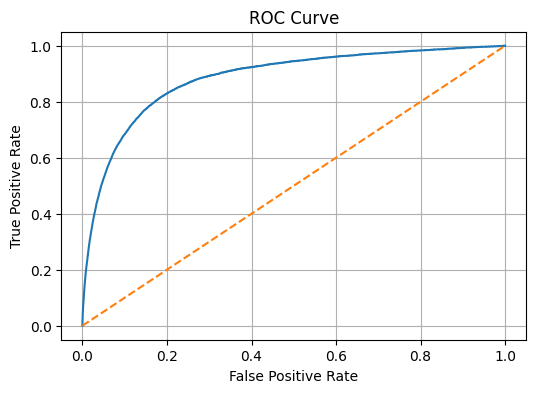

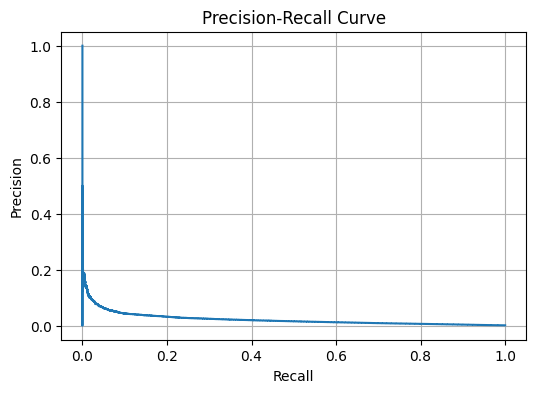

In [23]:
auc, pr_auc = model_auc_prauc(final_model, train_selected)

AUC: 0.8374
PR-AUC: 0.0256


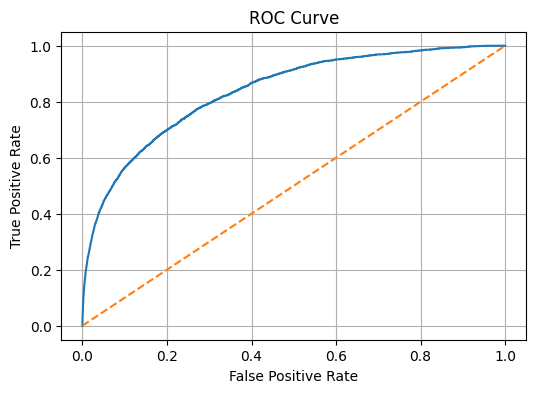

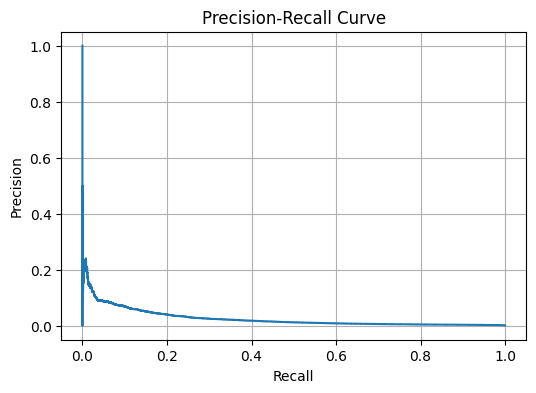

In [24]:
auc, pr_auc = model_auc_prauc(final_model, test_selected)

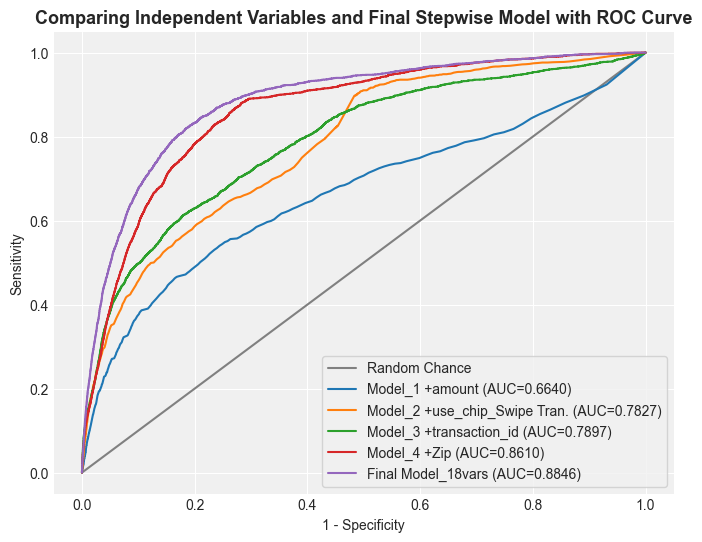

In [29]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score


def plot_multiple_roc(models, model_names, test_df, target_col="is_fraud"):
    """
    models: list of fitted statsmodels.Logit models
    model_names: list of strings
    test_df: test dataframe
    """
    plt.figure(figsize=(8, 6))
    plt.style.use('seaborn-v0_8-darkgrid')
    plt.rcParams['axes.facecolor'] = '#f0f0f0'

    # 隨機機率線
    plt.plot([0, 1], [0, 1], color='gray', linestyle='-', label='Random Chance')

    auc_values = {}

    for model, name in zip(models, model_names):
        # 取出模型變數
        vars_used = model.params.index.drop("const")
        X_test = sm.add_constant(test_df[vars_used])

        # 計算預測機率
        y_true = test_df[target_col]
        y_score = model.predict(X_test)

        # ROC 曲線
        fpr, tpr, _ = roc_curve(y_true, y_score)
        auc_val = roc_auc_score(y_true, y_score)
        auc_values[name] = auc_val

        plt.plot(fpr, tpr, label=f"{name} (AUC={auc_val:.4f})")

    plt.title("Comparing Independent Variables and Final Stepwise Model with ROC Curve", fontsize=13, fontweight='bold')
    plt.xlabel("1 - Specificity")
    plt.ylabel("Sensitivity")
    plt.legend(loc="lower right", frameon=True)
    plt.show()

    # 印出 AUC summary
    #print("AUC values:")
    #for name, val in auc_values.items():
    #    print(f"{name}: {val:.4f}")

# 假設你已經有以下模型：
# model_1 = sm.Logit(y_train, sm.add_constant(X_train[["X13"]])).fit(disp=False)
# model_2 = sm.Logit(y_train, sm.add_constant(X_train[["X17"]])).fit(disp=False)
# final_model = ...

# 範例呼叫
plot_multiple_roc(
    models=[model_0, model_2, model_3,model_4, final_model],
    model_names=["Model_1 +amount", "Model_2 +use_chip_Swipe Tran.", "Model_3 +transaction_id","Model_4 +Zip", "Final Model_18vars"],
    test_df=test_df,
    target_col="is_fraud"
)


## 04-4(d) 對照圖 amount 取log only

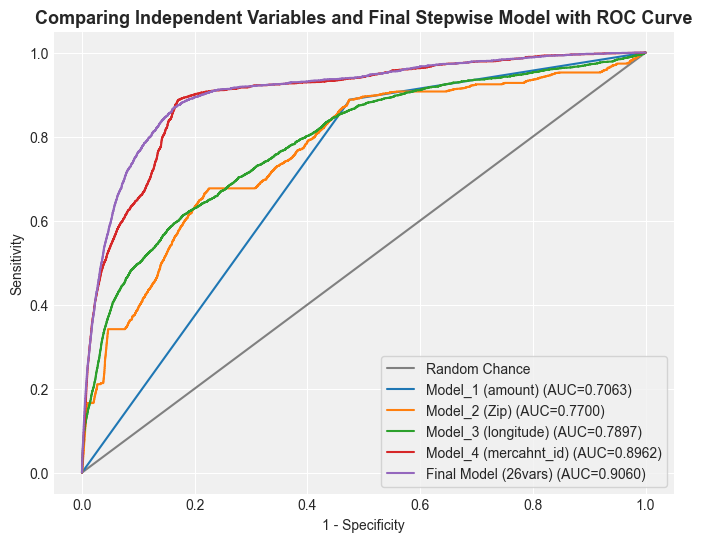

AUC values:
Model_1 (amount): 0.7063
Model_2 (Zip): 0.7700
Model_3 (longitude): 0.7897
Model_4 (mercahnt_id): 0.8962
Final Model (26vars): 0.9060


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

def plot_multiple_roc(models, model_names, test_df, target_col="is_fraud"):
    """
    models: list of fitted statsmodels.Logit models
    model_names: list of strings
    test_df: test dataframe
    """
    plt.figure(figsize=(8, 6))
    plt.style.use('seaborn-v0_8-darkgrid')
    plt.rcParams['axes.facecolor'] = '#f0f0f0'

    # 隨機機率線
    plt.plot([0, 1], [0, 1], color='gray', linestyle='-', label='Random Chance')

    auc_values = {}

    for model, name in zip(models, model_names):
        # 取出模型變數
        vars_used = model.params.index.drop("const")
        X_test = sm.add_constant(test_df[vars_used])

        # 計算預測機率
        y_true = test_df[target_col]
        y_score = model.predict(X_test)

        # ROC 曲線
        fpr, tpr, _ = roc_curve(y_true, y_score)
        auc_val = roc_auc_score(y_true, y_score)
        auc_values[name] = auc_val

        plt.plot(fpr, tpr, label=f"{name} (AUC={auc_val:.4f})")

    plt.title("Comparing Independent Variables and Final Stepwise Model with ROC Curve", fontsize=13, fontweight='bold')
    plt.xlabel("1 - Specificity")
    plt.ylabel("Sensitivity")
    plt.legend(loc="lower right", frameon=True)
    plt.show()

    # 印出 AUC summary
    print("AUC values:")
    for name, val in auc_values.items():
        print(f"{name}: {val:.4f}")

# 假設你已經有以下模型：
# model_1 = sm.Logit(y_train, sm.add_constant(X_train[["X13"]])).fit(disp=False)
# model_2 = sm.Logit(y_train, sm.add_constant(X_train[["X17"]])).fit(disp=False)
# final_model = ...

# 範例呼叫
plot_multiple_roc(
    models=[model_0, model_2, model_3, model_4, final_model],
    model_names=["Model_1 (amount)", "Model_2 (Zip)", "Model_3 (longitude)","Model_4 (mercahnt_id)", "Final Model (26vars)"],
    test_df=test_df,
    target_col="is_fraud"
)


## 04-5(a)_ Model BY SkLEARN

In [12]:
included=[
 'amount',
 'use_chip_Swipe Transaction',
 'transaction_id',
 'zip',
 'longitude',
 'credit_limit',
 'merchant_id',
 'num_credit_cards',
 'errors_missing_flag',
 'yearly_income',
 'mcc_code',
 'has_chip_YES',
 'latitude',
 'client_id_x',
 'credit_score',
 'retirement_age',
 'total_debt',
 'card_brand_Mastercard',
 'card_id',
 'current_age',
 'gender_Male',
 'cvv',
 'num_cards_issued',
 'card_type_Debit'
]


In [44]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from scipy.stats import chi2
import statsmodels.api as sm


def _compute_cov_and_se(model, X_scaled):
    n = X_scaled.shape[0]
    X_design = np.hstack([np.ones((n, 1)), X_scaled])
    p = model.predict_proba(X_scaled)[:, 1]
    W = p * (1 - p)

    # 增加小常數以避免奇異矩陣
    XtWX = X_design.T @ (W[:, None] * X_design) + np.eye(X_design.shape[1]) * 1e-8

    try:
        cov = np.linalg.inv(XtWX)
    except np.linalg.LinAlgError:
        cov = np.linalg.pinv(XtWX)

    se = np.sqrt(np.maximum(np.diag(cov), 0.0))
    return cov, se


def compute_not_in_eq(y_train, full_X_train_df, included_vars, excluded_vars):
    results = []
    eps = 1e-9

    # --- base model ---
    if len(included_vars) == 0:
        p_mean = np.clip(np.mean(y_train), eps, 1 - eps)
        base_ll = np.sum(y_train * np.log(p_mean) + (1 - y_train) * np.log(1 - p_mean))
    else:
        try:
            X_incl_sm = sm.add_constant(full_X_train_df[included_vars])
            base_model = sm.Logit(y_train, X_incl_sm).fit(disp=False)
            base_ll = base_model.llf
        except Exception:
            X_incl_sk = full_X_train_df[included_vars].astype(float)
            lr_base = LogisticRegression(solver="liblinear", max_iter=2000)
            lr_base.fit(X_incl_sk, y_train)
            p_pred_base = np.clip(lr_base.predict_proba(X_incl_sk)[:, 1], eps, 1 - eps)
            base_ll = np.sum(y_train * np.log(p_pred_base) + (1 - y_train) * np.log(1 - p_pred_base))

    # --- test each excluded var ---
    for var in excluded_vars:
        try:
            full_vars = included_vars + [var] if len(included_vars) > 0 else [var]
            X_full_df = full_X_train_df[full_vars].copy()

            try:
                X_full_sm = sm.add_constant(X_full_df)
                full_model = sm.Logit(y_train, X_full_sm).fit(disp=False)
                full_ll = full_model.llf
            except Exception:
                X_full_sk = X_full_df.astype(float)
                lr_full = LogisticRegression(solver="liblinear", max_iter=2000)
                lr_full.fit(X_full_sk, y_train)
                p_pred_full = np.clip(lr_full.predict_proba(X_full_sk)[:, 1], eps, 1 - eps)
                full_ll = np.sum(y_train * np.log(p_pred_full) + (1 - y_train) * np.log(1 - p_pred_full))

            lr_stat = 2.0 * (full_ll - base_ll)
            pval = chi2.sf(lr_stat, df=1)

            results.append({
                "Independent Variable": var,
                "Score Statistic (LRT)": round(float(lr_stat), 3),
                "Significance": round(float(pval), 4)
            })
        except KeyError:
            results.append({
                "Independent Variable": var,
                "Score Statistic (LRT)": None,
                "Significance": None
            })
        except Exception:
            results.append({
                "Independent Variable": var,
                "Score Statistic (LRT)": None,
                "Significance": None
            })

    return pd.DataFrame(results)


def sklearn_logit_with_k(train_df, test_df, dep_var, included, k=314657018):
    """
    主函式（修正版）：確保整體模型 LRT 正向（SPSS 一致），
    Change_from_Base 為改善幅度，Change_pvalue 為整體模型顯著性。
    """
    # === 1. 準備資料 ===
    y_train = train_df[dep_var].astype(int).values
    y_test = test_df[dep_var].astype(int).values

    if k == 314657018:
        selected_vars = included
    else:
        selected_vars = included[:k]

    X_train = train_df[selected_vars].astype(float).copy()
    X_test = test_df[selected_vars].astype(float).copy()

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # === 2. 建立模型 ===
    model = LogisticRegression(solver="liblinear", max_iter=2000, class_weight="balanced")
    model.fit(X_train_scaled, y_train)

    # === 3. 模型擬合度 ===
    eps = 1e-9
    p_pred = np.clip(model.predict_proba(X_train_scaled)[:, 1], eps, 1 - eps)
    full_ll = np.sum(y_train * np.log(p_pred) + (1 - y_train) * np.log(1 - p_pred))

    # Null model (只有截距)
    p_mean = np.clip(np.mean(y_train), eps, 1 - eps)
    base_ll = np.sum(y_train * np.log(p_mean) + (1 - y_train) * np.log(1 - p_mean))

    # 注意：SPSS 用 (-2LL_null) - (-2LL_model)
    delta_minus2LL = -2 * base_ll - (-2 * full_ll)
    LR_chi2 = max(delta_minus2LL, 0)
    LR_df = len(selected_vars)
    LR_pvalue = float(chi2.sf(LR_chi2, df=LR_df))

    n = len(y_train)
    r2_cox_snell = 1 - np.exp(-LR_chi2 / n)
    denom = 1 - np.exp(-2 * base_ll / n)
    r2_nagelkerke = r2_cox_snell / denom if denom != 0 else np.nan
    r2_mcfadden = 1 - (full_ll / base_ll)

    overall_fit = pd.DataFrame({
        "Measure": [
            "-2 Log Likelihood (−2LL) value",
            "Cox and Snell R2",
            "Nagelkerke R2",
            "Pseudo R2 (McFadden)",
            "Likelihood Ratio χ2",
        ],
        "Value": [
            round(-2 * full_ll, 3),
            round(r2_cox_snell, 3),
            round(r2_nagelkerke, 3),
            round(r2_mcfadden, 3),
            round(LR_chi2, 3)
        ],
        "Change_from_Base": [round(LR_chi2, 3), "", "", "", ""],
        "Change_pvalue": [f"{LR_pvalue:.6f}", "", "", "", ""]
    })

    # === 4. 係數表 ===
    coef = model.coef_[0]
    intercept = model.intercept_[0]
    cov, se_all = _compute_cov_and_se(model, X_train_scaled)
    se_beta = se_all[1:]
    se_intercept = se_all[0]

    wald_vals, pvals = [], []
    for b, se in zip(coef, se_beta):
        if se == 0 or np.isnan(se):
            wald_vals.append(np.nan)
            pvals.append(np.nan)
        else:
            w = (b / se) ** 2
            wald_vals.append(w)
            pvals.append(float(chi2.sf(w, df=1)))

    intercept_wald = (intercept / se_intercept) ** 2 if se_intercept != 0 else np.nan
    intercept_pval = float(chi2.sf(intercept_wald, df=1)) if not np.isnan(intercept_wald) else np.nan

    coef_df = pd.DataFrame({
        "Independent Variable": ["(Intercept)"] + selected_vars,
        "B": np.round([intercept] + coef.tolist(), 6),
        "Std. Error": [round(float(x), 6) for x in se_all],
        "Wald": [round(float(intercept_wald), 3)] +
                [round(float(x), 3) if not np.isnan(x) else None for x in wald_vals],
        "df": [1] * (len(coef) + 1),
        "Sig.": [round(float(intercept_pval), 6)] +
                [round(float(x), 6) if not np.isnan(x) else None for x in pvals],
        "Exp(B)": np.round(np.exp([intercept] + coef.tolist()), 6)
    })

    # === 5. Variables not in Equation ===
    excluded_vars = [v for v in included if v not in selected_vars]
    not_in_eq_df = compute_not_in_eq(y_train, train_df, selected_vars, excluded_vars)

    return overall_fit, coef_df, not_in_eq_df, model, scaler


In [45]:
overall_fit, coef_df, not_in_eq_df, skmodel, scaler = sklearn_logit_with_k(
    train_df, test_df, dep_var="is_fraud", included=included, k=18
)

print("=== Overall Model Fit ===")
print(overall_fit)
print("\n=== Variables in the Equation ===")
print(coef_df)
print("\n=== Variables Not in the Equation ===")
print(not_in_eq_df)

=== Overall Model Fit ===
                          Measure        Value Change_from_Base Change_pvalue
0  -2 Log Likelihood (−2LL) value  6025127.624                0      1.000000
1                Cox and Snell R2        0.000                               
2                   Nagelkerke R2       -0.000                               
3            Pseudo R2 (McFadden)      -36.868                               
4             Likelihood Ratio χ2        0.000                               

=== Variables in the Equation ===
          Independent Variable         B  Std. Error         Wald  df  \
0                  (Intercept) -1.595928    0.001322  1457913.539   1   
1                       amount  0.343696    0.001158    88090.809   1   
2   use_chip_Swipe Transaction -1.063118    0.001606   438291.733   1   
3               transaction_id -0.382334    0.001469    67699.458   1   
4                          zip -1.834116    0.002083   775487.070   1   
5                    longitude -0

In [37]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix


def cutoff_analysis_sklearn(model, scaler, df, included_vars, target_col="is_fraud", cutoffs=None):
    """
    對 sklearn logistic regression 模型做 cutoff 分析
    （模擬 SPSS Table 8.7 結果）
    
    Parameters
    ----------
    model : sklearn.linear_model.LogisticRegression
        已訓練完成的 logistic regression 模型。
    scaler : sklearn.preprocessing.StandardScaler
        與訓練模型時一致的 scaler。
    df : pandas.DataFrame
        包含所有預測變數與 target 欄位的資料集。
    included_vars : list
        模型使用的變數名稱（與訓練時一致）。
    target_col : str, default='is_fraud'
        真實標籤欄位名稱。
    cutoffs : list or array, optional
        要分析的 cutoff 清單，預設為 np.arange(0, 1.01, 0.05)。

    Returns
    -------
    pd.DataFrame
        包含各 cutoff 的混淆矩陣與各種評估指標。
    """
    if cutoffs is None:
        cutoffs = np.arange(0, 1.01, 0.05)

    # === 準備資料 ===
    y_true = df[target_col].astype(int).values

    # 保證與 scaler 的 feature_names 對齊
    feature_order = [col for col in scaler.feature_names_in_ if col in df.columns]
    missing = [col for col in scaler.feature_names_in_ if col not in df.columns]
    if missing:
        print(f"⚠️ Warning: 以下欄位在資料集中缺失，將被忽略：{missing}")

    X = df[feature_order].astype(float).copy()
    X_scaled = scaler.transform(X)

    # === 預測機率 ===
    y_prob = model.predict_proba(X_scaled)[:, 1]

    rows = []
    for cutoff in cutoffs:
        y_pred = (y_prob >= cutoff).astype(int)

        # confusion_matrix 的排列是 [[TN, FP], [FN, TP]]
        cm = confusion_matrix(y_true, y_pred, labels=[0, 1])

        if cm.shape == (2, 2):
            TN, FP, FN, TP = cm.ravel()
        else:
            TN = FP = FN = TP = 0

        total = TP + TN + FP + FN
        accuracy = (TP + TN) / total if total > 0 else np.nan
        sensitivity = TP / (TP + FN) if (TP + FN) > 0 else np.nan
        specificity = TN / (TN + FP) if (TN + FP) > 0 else np.nan
        youden = (sensitivity + specificity - 1) if (
            not np.isnan(sensitivity) and not np.isnan(specificity)
        ) else np.nan
        ppv = TP / (TP + FP) if (TP + FP) > 0 else np.nan
        npv = TN / (TN + FN) if (TN + FN) > 0 else np.nan
        f1 = 2 * TP / (2 * TP + FP + FN) if (2 * TP + FP + FN) > 0 else np.nan

        rows.append({
            "Cutoff": round(cutoff, 2),
            "TN": TN, "FP": FP, "FN": FN, "TP": TP,
            "Accuracy (%)": round(accuracy * 100, 2) if not np.isnan(accuracy) else "NC",
            "Sensitivity (%)": round(sensitivity * 100, 2) if not np.isnan(sensitivity) else "NC",
            "Specificity (%)": round(specificity * 100, 2) if not np.isnan(specificity) else "NC",
            "Youden Index": round(youden, 4) if not np.isnan(youden) else "NC",
            "PPV (%)": round(ppv * 100, 2) if not np.isnan(ppv) else "NC",
            "NPV (%)": round(npv * 100, 2) if not np.isnan(npv) else "NC",
            "F1 Score": round(f1, 4) if not np.isnan(f1) else "NC"
        })

    df_result = pd.DataFrame(rows)
    return df_result


In [38]:
# === 範例執行 ===
cutoff_table_all = cutoff_analysis_sklearn(
    skmodel,            # 來自 sklearn_logit_with_k 的 model
    scaler,           # 對應的標準化器
    test_df,          # 測試資料
    included[:3],     # 與模型相同的自變數
    target_col="is_fraud"
    
)

print(cutoff_table_all.to_string(index=False))

 Cutoff      TN      FP   FN   TP  Accuracy (%)  Sensitivity (%)  Specificity (%)  Youden Index PPV (%) NPV (%)  F1 Score
   0.00       0 1780252    0 2741          0.15           100.00             0.00        0.0000    0.15      NC    0.0031
   0.05  439706 1340546   51 2690         24.81            98.14            24.70        0.2284     0.2   99.99    0.0040
   0.10  710671 1069581  104 2637         40.01            96.21            39.92        0.3613    0.25   99.99    0.0049
   0.15  890102  890150  141 2600         50.07            94.86            50.00        0.4485    0.29   99.98    0.0058
   0.20 1015615  764637  169 2572         57.11            93.83            57.05        0.5088    0.34   99.98    0.0067
   0.25 1110777  669475  190 2551         62.44            93.07            62.39        0.5546    0.38   99.98    0.0076
   0.30 1188564  591688  211 2530         66.80            92.30            66.76        0.5907    0.43   99.98    0.0085
   0.35 1254668  525584 

## 04-5(b)_對應 sklearn 版本的多模型 ROC 繪圖

In [39]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

def plot_multiple_roc_sklearn(models, scalers, model_names, test_df, included_var_sets, target_col="is_fraud"):
    """
    對應 sklearn LogisticRegression 版本的多模型 ROC 圖比較
    
    models: list of fitted sklearn models
    scalers: list of對應的 StandardScaler（每個模型一個）
    model_names: list of模型名稱
    test_df: 測試資料
    included_var_sets: list of各模型使用的變數名稱（list of list）
    target_col: 目標變數名稱
    """
    plt.figure(figsize=(8, 6))
    plt.style.use('seaborn-v0_8-darkgrid')
    plt.rcParams['axes.facecolor'] = '#f0f0f0'

    # 隨機機率線
    plt.plot([0, 1], [0, 1], color='gray', linestyle='-', label='Random Chance')

    auc_values = {}

    for model, scaler, name, vars_used in zip(models, scalers, model_names, included_var_sets):
        # 準備測試資料
        X_test = test_df[vars_used].astype(float)
        X_test_scaled = scaler.transform(X_test)
        y_true = test_df[target_col].astype(int)

        # 模型預測機率
        y_score = model.predict_proba(X_test_scaled)[:, 1]

        # ROC 曲線與 AUC
        fpr, tpr, _ = roc_curve(y_true, y_score)
        auc_val = roc_auc_score(y_true, y_score)
        auc_values[name] = auc_val

        plt.plot(fpr, tpr, lw=2, label=f"{name} (AUC={auc_val:.4f})")

    plt.title("Comparing Independent Variables and Final Stepwise Model with ROC Curve", fontsize=13, fontweight='bold')
    plt.xlabel("1 - Specificity (False Positive Rate)")
    plt.ylabel("Sensitivity (True Positive Rate)")
    plt.legend(loc="lower right", frameon=True)
    plt.tight_layout()
    plt.show()

    # 印出 AUC Summary
    print("AUC values:")
    for name, val in auc_values.items():
        print(f"{name}: {val:.4f}")


In [42]:
# 範例：建立四個不同變數集的模型
skmodel_1_info = sklearn_logit_with_k(train_df, test_df, dep_var="is_fraud", included=included, k=1)
skmodel_2_info = sklearn_logit_with_k(train_df, test_df, dep_var="is_fraud", included=included, k=2)
skmodel_3_info = sklearn_logit_with_k(train_df, test_df, dep_var="is_fraud", included=included, k=3)
skmodel_final_info = sklearn_logit_with_k(train_df, test_df, dep_var="is_fraud", included=included, k=18)


# 解包結果 (overall_fit, coef_df, not_in_eq_df, model, scaler)
_, _, _, skmodel_1, skscaler_1 = skmodel_1_info
_, _, _, skmodel_2, skscaler_2 = skmodel_2_info
_, _, _, skmodel_3, skscaler_3 = skmodel_3_info
_, _, _, skmodel_final, skscaler_final = skmodel_final_info

# 對應的變數集
vars_1 = included[:1]
vars_2 = included[:2]
vars_3 = included[:3]
vars_final = included[:18]  # 全部變數

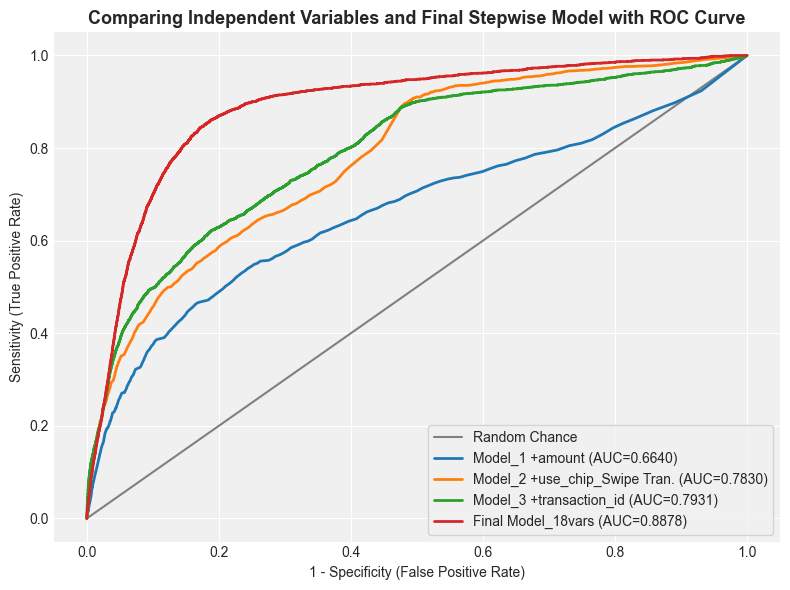

AUC values:
Model_1 +amount: 0.6640
Model_2 +use_chip_Swipe Tran.: 0.7830
Model_3 +transaction_id: 0.7931
Final Model_18vars: 0.8878


In [ ]:
plot_multiple_roc_sklearn(
    models=[skmodel_1, skmodel_2, skmodel_3, skmodel_final],
    scalers=[skscaler_1, skscaler_2, skscaler_3, skscaler_final],
    model_names=["Model_1 +amount", 
                 "Model_2 +use_chip_Swipe Tran.", 
                 "Model_3 +transaction_id", 
                 "Final Model_18vars"],
    test_df=test_df,
    included_var_sets=[vars_1, vars_2, vars_3, vars_final],
    target_col="is_fraud"
)

共有 18 個變數可供建模
總共建立 18 個模型（含最終模型）


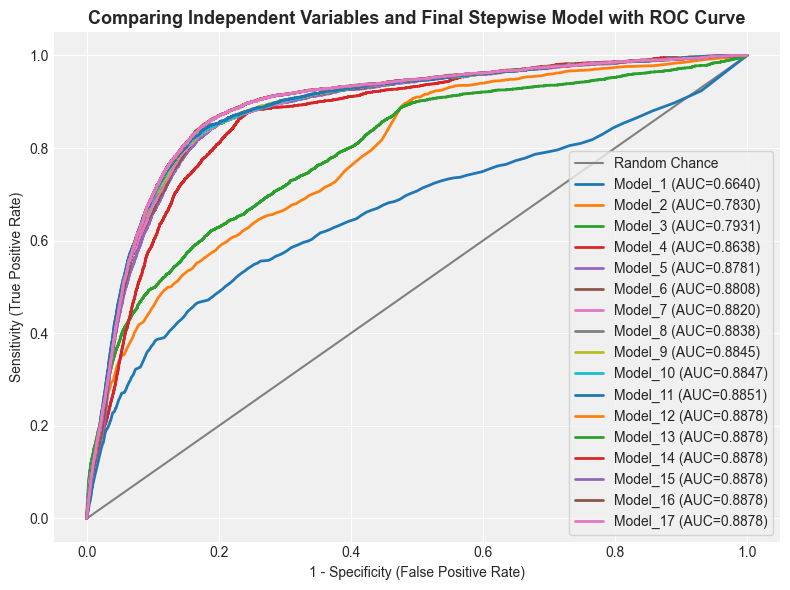

AUC values:
Model_1: 0.6640
Model_2: 0.7830
Model_3: 0.7931
Model_4: 0.8638
Model_5: 0.8781
Model_6: 0.8808
Model_7: 0.8820
Model_8: 0.8838
Model_9: 0.8845
Model_10: 0.8847
Model_11: 0.8851
Model_12: 0.8878
Model_13: 0.8878
Model_14: 0.8878
Model_15: 0.8878
Model_16: 0.8878
Model_17: 0.8878


In [43]:
# 計算 included 長度
n_vars = 18
print(f"共有 {n_vars} 個變數可供建模")

# 建立模型與 scaler 的容器
models = []
scalers = []
model_names = []
included_var_sets = []

# 自動迴圈建立模型
for k in range(1, n_vars):
    model_info = sklearn_logit_with_k(
        train_df, test_df, dep_var="is_fraud", included=included, k=k
    )
    _, _, _, model, scaler = model_info
    
    models.append(model)
    scalers.append(scaler)
    included_var_sets.append(included[:k])
    model_names.append(f"Model_{k}")

print(f"總共建立 {n_vars} 個模型（含最終模型）")

# 🔹 繪製多模型 ROC 比較圖
plot_multiple_roc_sklearn(
    models=models,
    scalers=scalers,
    model_names=model_names,
    test_df=test_df,
    included_var_sets=included_var_sets,
    target_col="is_fraud"
)

# 05_地區分析

驚人發現 "2018-01-01 00:00:00" 到 "2019-10-31 23:59:59"的交易資料中，詐騙高度集中在網路交易、境外交易、ohio州

In [63]:
df=train_df

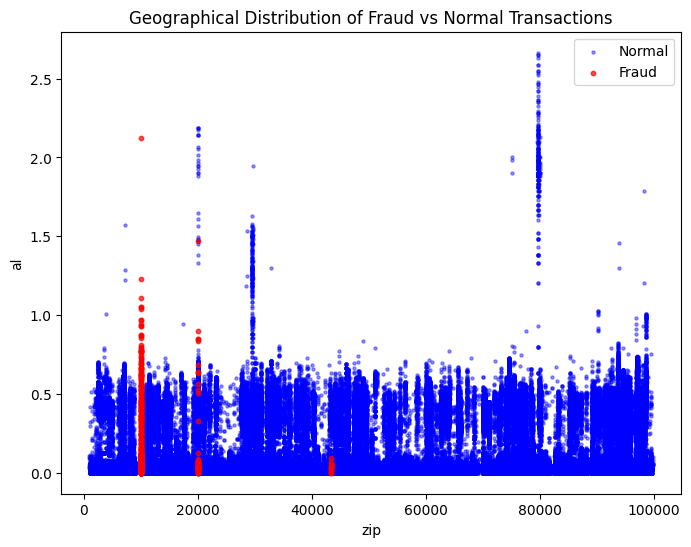

In [56]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.scatter(df[df['is_fraud']==0]['zip'], df[df['is_fraud']==0]['al'],
            s=5, alpha=0.4, label='Normal', color='blue')
plt.scatter(df[df['is_fraud']==1]['zip'], df[df['is_fraud']==1]['al'],
            s=10, alpha=0.7, label='Fraud', color='red')
plt.xlabel('zip')
plt.ylabel('al')
plt.title('Geographical Distribution of Fraud vs Normal Transactions')
plt.legend()
plt.show()


In [30]:
import folium

# 建立地圖中心（以資料平均位置為中心）
center_lat = df['latitude'].mean()
center_lon = df['longitude'].mean()

m = folium.Map(location=[center_lat, center_lon], zoom_start=6)

# 加入交易點
for _, row in df.iterrows():
    color = 'red' if row['is_fraud'] == 1 else 'blue'
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=2,
        color=color,
        fill=True,
        fill_opacity=0.5
    ).add_to(m)

m.save('fraud_map.html')


KeyboardInterrupt: 

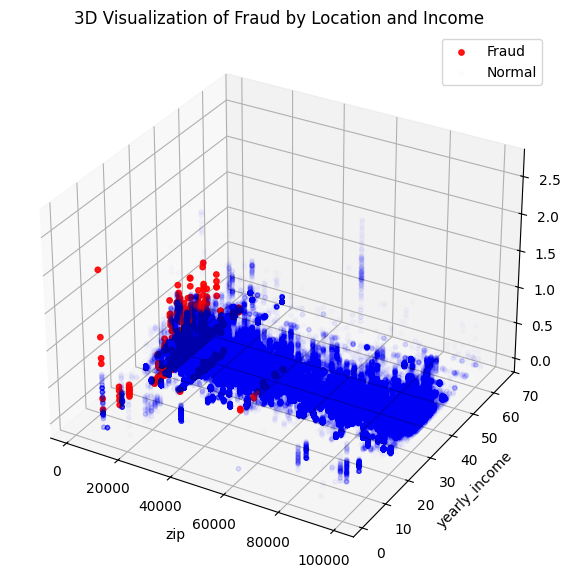

In [57]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

df["al"]=df['amount']/df["credit_limit"]

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')

# 各類別上色
# 先畫 Fraud
ax.scatter(
           df[df['is_fraud']==1]['zip'],
          
           df[df['is_fraud']==1]['yearly_income'],
           df[df['is_fraud']==1]['al'],
           c='red', label='Fraud', alpha=0.9, s=15)

# 再畫 Normal
ax.scatter(
           df[df['is_fraud']==0]['zip'],
           
           df[df['is_fraud']==0]['yearly_income'],
           df[df['is_fraud']==0]['al'],
           c='blue', label='Normal', alpha=0.01, s=10)


ax.set_xlabel('zip')
ax.set_zlabel('al')
ax.set_ylabel('yearly_income')
ax.set_title('3D Visualization of Fraud by Location and Income')
ax.legend()
plt.show()


In [52]:
df["al"]=df['amount']/df["credit_limit"]

In [58]:
df["zip"]==10000

12845534     True
12895409    False
12646582    False
11626175    False
12218212    False
            ...  
11247464    False
12403412    False
10870934    False
12465326    False
11940857    False
Name: zip, Length: 1369550, dtype: bool

In [62]:
fraud = df[df["is_fraud"] == 1]

# 99_其他code

In [9]:
merged.to_csv("merged.csv", index=False)